# 

In [1]:
import pandas as pd
import os
import shutil
from zipfile import ZipFile, BadZipFile
import json
import numpy as np
from torch.cuda.amp import GradScaler, autocast
from sklearn.cluster import KMeans
from collections import Counter

import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

print(np.__version__)

1.26.4


In [2]:
def check_gpu():
    if torch.cuda.is_available():
        print("CUDA está disponible.")
        print(f"Hay {torch.cuda.device_count()} GPU(s) disponible(s).")
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA no está disponible. No hay GPU accesible.")

check_gpu()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA está disponible.
Hay 1 GPU(s) disponible(s).
GPU 0: NVIDIA GeForce RTX 2060


## TRANSFORMER ARCHITECTURE

In [3]:
MAX_SEQ_LEN = 128 # max num of words per phrase for translate

In [4]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_seq_len = MAX_SEQ_LEN):
        super().__init__()
        self.pos_embed_matrix = torch.zeros(max_seq_len, d_model, device=device)
        token_pos = torch.arange(0, max_seq_len, dtype = torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() 
                             * (-math.log(10000.0)/d_model))
        self.pos_embed_matrix[:, 0::2] = torch.sin(token_pos * div_term)
        self.pos_embed_matrix[:, 1::2] = torch.cos(token_pos * div_term)
        self.pos_embed_matrix = self.pos_embed_matrix.unsqueeze(0).transpose(0,1)
        
    def forward(self, x):
#         print(self.pos_embed_matrix.shape)
#         print(x.shape)
        return x + self.pos_embed_matrix[:x.size(0), :]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model = 512, num_heads = 8):
        super().__init__()
        assert d_model % num_heads == 0, 'Embedding size not compatible with num heads'
        
        self.d_v = d_model // num_heads
        self.d_k = self.d_v
        self.num_heads = num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def forward(self, Q, K, V, mask = None):
        batch_size = Q.size(0)
        '''
        Q, K, V -> [batch_size, seq_len, num_heads*d_k]
        after transpose Q, K, V -> [batch_size, num_heads, seq_len, d_k]
        '''
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )
        
        weighted_values, attention = self.scale_dot_product(Q, K, V, mask)
        weighted_values = weighted_values.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads*self.d_k)
        weighted_values = self.W_o(weighted_values)
        
        return weighted_values, attention
        
        
    def scale_dot_product(self, Q, K, V, mask = None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention = F.softmax(scores, dim = -1)
        weighted_values = torch.matmul(attention, V)
        
        return weighted_values, attention
        

class PositionFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))
    
class EncoderSubLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.droupout1 = nn.Dropout(dropout)
        self.droupout2 = nn.Dropout(dropout)
    
    def forward(self, x, mask = None):
        attention_score, _ = self.self_attn(x, x, x, mask)
        x = x + self.droupout1(attention_score)
        x = self.norm1(x)
        x = x + self.droupout2(self.ffn(x))
        return self.norm2(x)

class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([EncoderSubLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class DecoderSubLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        
    def forward(self, x, encoder_output, target_mask=None, encoder_mask=None):
        attention_score, _ = self.self_attn(x, x, x, target_mask)
        x = x + self.dropout1(attention_score)
        x = self.norm1(x)
        
        encoder_attn, _ = self.cross_attn(x, encoder_output, encoder_output, encoder_mask)
        x = x + self.dropout2(encoder_attn)
        x = self.norm2(x)
        
        ff_output = self.feed_forward(x)
        x = x + self.dropout3(ff_output)
        return self.norm3(x)
        
class Decoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([DecoderSubLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x, encoder_output, target_mask, encoder_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, target_mask, encoder_mask)
        return self.norm(x)

In [5]:
class Transformer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers,
                 input_vocab_size, max_len=MAX_SEQ_LEN, dropout=0.1):
        super().__init__()
        self.encoder_embedding = nn.Embedding(input_vocab_size, d_model)
        self.pos_embedding = PositionalEmbedding(d_model, max_len)
        self.encoder = Encoder(d_model, num_heads, d_ff, num_layers, dropout)
        self.sep_token_id = 2

        # Embeddings
        self._cached_source_embeddings = None
        self._all_embeddings = None
        
    def forward(self, source):
        # Encoder mask
        source_mask = self.mask(source)
        # Embedding and positional Encoding
        source = self.encoder_embedding(source) * math.sqrt(self.encoder_embedding.embedding_dim)
        self._cached_source_embeddings = source
        source = self.pos_embedding(source)
        # Encoder
        encoder_output = self.encoder(source, source_mask)
        
        return encoder_output
        
    def get_embeddings(self):
        if self._all_embeddings is None:
            raise ValueError("Embeddings not computed yet. Call forward() first.")
        return self._all_embeddings
    
    def mask(self, source):
        source_mask = (source != 0).unsqueeze(1).unsqueeze(2)
        
        if self.sep_token_id is not None:
            seq_len = source.size(1)
            sep_positions = (source == self.sep_token_id).nonzero(as_tuple=True)[1]
            
            attention_block_mask = torch.ones(seq_len, seq_len, dtype=torch.bool, device=source.device)

            last_sep_pos = -1
            for sep_pos in sep_positions:
                attention_block_mask[last_sep_pos + 1 : sep_pos, last_sep_pos + 1 : sep_pos] = 0
                last_sep_pos = sep_pos

            source_mask = source_mask & attention_block_mask.unsqueeze(0).unsqueeze(0)

        return source_mask

        

## Simple test

In [6]:
seq_len_source = 10
seq_len_target = 10
batch_size = 2
input_vocab_size = 50
target_vocab_size = 50

source = torch.randint(1, input_vocab_size, (batch_size, seq_len_source))

d_model = 512
num_heads = 8
d_ff = 2048
num_layers = 6

model = Transformer(d_model, num_heads, d_ff, num_layers,
                   input_vocab_size, max_len=MAX_SEQ_LEN, dropout=0.1)

model = model.to(device)
source = source.to(device)

output = model(source)
#Expected output shape -> [batch, seq_len_target, target_vocab_size] i.e [2, 10, 50]
print(f'output.shape {output.shape}')
print(source)

output.shape torch.Size([2, 10, 512])
tensor([[31, 43, 29, 24,  2, 16, 38,  7,  7, 35],
        [ 5, 48, 41,  5, 30, 18, 25, 10, 46, 49]], device='cuda:0')


## DATA PREPROCESSING: Creation of build_vocab and company...

In [7]:
import pandas as pd
import os
from zipfile import ZipFile, BadZipFile
import json

metrics = pd.read_csv('metrics_attr.csv')

# Filter by Action Genre
metrics_action = metrics[(metrics['Main Genre'] == 'Action')]
metrics_non_action = metrics[(metrics['Main Genre'] != 'Action')]


# Check the filenames for collect
filenames_action = list(metrics_action['Name'])
filenames_non_action = list(metrics_non_action['Name'])
# Create txt for made the shell script
with open('filenames_action_global.txt', 'w') as names:
     for name in filenames_action:
        names.write(name + '\n')


#for project in filenames_action:
 #   sb3_path = f'./projects_sb3/{project}'
  #  if os.path.isfile(sb3_path):
   #     shutil.copy(sb3_path, './sb3_action_global')
    #    print(f'The project {project} has been success copy')
    #else:
     #   print(f'The project {project} doesnt exists')

In [8]:
def load_json_project(path_projectsb3):
    try:
        zip_file = ZipFile(path_projectsb3, "r")
        json_project = json.loads(zip_file.open("project.json").read())
        return json_project
    except BadZipFile:
        print('Bad zipfile')

def process(json_project):
    seq_num = 0
    dict_total_blocks = {}
    
    list_total_blocks = []

    for key, list_info in json_project.items():
        if key == "targets":
            for dict_target in list_info:
                target_name = dict_target.get('name')
                if target_name:
                    dict_total_blocks[target_name] = {}
                    dict_total_blocks[target_name][f'Seq_{seq_num}'] = []
                blocks = dict_target.get('blocks')
                if blocks:
                    for block_id, block_info in blocks.items():
                        if isinstance(block_info, dict):
                            topLevel = block_info.get('topLevel')
                            if topLevel:
                                seq_num += 1
                                dict_total_blocks[target_name][f'Seq_{seq_num}'] = []
                            opcode = block_info.get('opcode')
                            if opcode:
                                
                                dict_total_blocks[target_name][f'Seq_{seq_num}'].append(opcode)
                            list_total_blocks.append(block_info)
                            #dict_total_blocks[block_id] = block_info
    return dict_total_blocks


# ----------------- SCRIPTS GLOBAL (local context) ----------------------------------
dict_total_blocks = {}
scripts_global = []
list_total_blocks = []
print(len(filenames_action))
for project in filenames_action:
    sb3_path = os.path.join('.','sb3_action_global',project)
    if os.path.isfile(sb3_path):
        #print(project)
        json_project = load_json_project(sb3_path)
        dict_total_blocks = process(json_project)

        for sprite, seqs in dict_total_blocks.items():
            for idx, block_list in seqs.items():
                if block_list != []:
                    scripts_global.append(" ".join(block_list))

# ----------------- SCRIPTS TARGET ----------------------------------

scripts_train1 = []
scripts_train2 = []
for idx, project in enumerate(filenames_action):
    sb3_path = os.path.join('.','sb3_action_global',project)
    if os.path.isfile(sb3_path):
        #print(project)
        json_project = load_json_project(sb3_path)
        dict_total_blocks = process(json_project)

        for sprite, seqs in dict_total_blocks.items():
            for block_list in seqs.values():
                if block_list != []:
                    if idx < math.floor(len(filenames_action)/2):
                        scripts_train1.append(" ".join(block_list))
                    else:
                        scripts_train2.append(" ".join(block_list))


# ----------------- SCRIPTS NEGTATIVE  ----------------------------------
scripts_train3 = []
for project in filenames_non_action:
    sb3_path = os.path.join('.','sb3_non_action',project)
    if os.path.isfile(sb3_path):
        #print(project)
        json_project = load_json_project(sb3_path)
        dict_total_blocks = process(json_project)

        for sprite, seqs in dict_total_blocks.items():
            for idx, block_list in seqs.items():
                if block_list != []:
                    scripts_train3.append(" ".join(block_list))

# ----------------- SCRIPTS GLOBAL (global context)  ----------------------------------

dict_total_blocks = {}
scripts_global_global = []
list_total_blocks = []
print(len(filenames_action))
print(filenames_action[0])
for project in filenames_action:
    
    sb3_path = os.path.join('.','sb3_action_global',project)
    if os.path.isfile(sb3_path):
        #print(project)
        json_project = load_json_project(sb3_path)
        dict_total_blocks = process(json_project)

        for sprite, seqs in dict_total_blocks.items():
            global_seqs = []
            #print("project:", project)
            #print(seqs)
            #print("Sprite",sprite)
            
            for idx, block_list in seqs.items():
                if block_list != []:
                    global_seqs.append(" ".join(block_list))
                    global_seqs.append("<SCRIPT_END>")
            if global_seqs != []:
                global_seqs.pop(-1)
            
            scripts_global_global.append(" ".join(global_seqs))


# ----------------- SCRIPTS TARGET (POSITIV) (global context)  ----------------------------------

scripts_train1_global = []
scripts_train2_global = []
dict_total_blocks = {}
list_total_blocks = []
print(len(filenames_action))
for idx, project in enumerate(filenames_action):
    
    sb3_path = os.path.join('.','sb3_action_global',project)
    if os.path.isfile(sb3_path):
        #print(project)
        json_project = load_json_project(sb3_path)
        dict_total_blocks = process(json_project)

        for sprite, seqs in dict_total_blocks.items():
            global_seqs = []
            #print("project:", project)
            #print(seqs)
            #print("Sprite",sprite)
            
            for block_list in seqs.values():
                if block_list != []:  
                    global_seqs.append(" ".join(block_list))
                    global_seqs.append("<SCRIPT_END>")
            if global_seqs != []:
                global_seqs.pop(-1)
        
            if int(idx) < math.floor(len(filenames_action)/2):
                scripts_train1_global.append(" ".join(global_seqs))
            else:
                scripts_train2_global.append(" ".join(global_seqs))

# ----------------- SCRIPTS NEGATIVE (global context) -----------------------------

dict_total_blocks = {}
scripts_train3_global= []
list_total_blocks = []
print(len(filenames_non_action))
for project in filenames_non_action:
    
    sb3_path = os.path.join('.','sb3_non_action',project)
    if os.path.isfile(sb3_path):
        #print(project)
        json_project = load_json_project(sb3_path)
        dict_total_blocks = process(json_project)

        for sprite, seqs in dict_total_blocks.items():
            global_seqs = []
            #print("project:", project)
            #print(seqs)
            #print("Sprite",sprite)
            
            for idx, block_list in seqs.items():
                if block_list != []:
                    global_seqs.append(" ".join(block_list))
                    global_seqs.append("<SCRIPT_END>")
            if global_seqs != []:
                global_seqs.pop(-1)
            
            scripts_train3_global.append(" ".join(global_seqs))


# universal_scripts -> scripts of all genres for local context
# scripts_global -> global scripts (local context)... each index of the list its an scripts ACTION
# scripts_train1 -> src
# scritps_train2 -> trg
# scritps_train3 -> negative
# scripts_global_global -> global scripts (global context)... each index of the list its all project scripts 

# --------------------- LOCAL CONTEXT ---------------------------------------
min_len = min(len(scripts_train1), len(scripts_train2), len(scripts_train3))
scripts_train1 = scripts_train1[:min_len]
scripts_train2 = scripts_train2[:min_len]
scripts_train3 = scripts_train3[:min_len]

scripts_universal = scripts_train1 + scripts_train2 + scripts_train3
scripts_global = ['<sos> ' + script + ' <eos>' for script in scripts_global]
scripts_train1 = ['<sos> ' + script + ' <eos>' for script in scripts_train1]
scripts_train2 = ['<sos> ' + script + ' <eos>' for script in scripts_train2]
scripts_train3 = ['<sos> ' + script + ' <eos>' for script in scripts_train3]

# --------------------- GLOBAL CONTEXT ---------------------------------------
min_len = min(len(scripts_train1_global), len(scripts_train2_global), len(scripts_train3_global))
scripts_train1_global = scripts_train1_global[:min_len]
scripts_train2_global = scripts_train2_global[:min_len]
scripts_train3_global = scripts_train3_global[:min_len]

scripts_universal_global = scripts_train1_global + scripts_train2_global + scripts_train3_global
scripts_global_global = ['<sos> ' + script + ' <eos>' for script in scripts_global_global]
scripts_train1_global = ['<sos> ' + script + ' <eos>' for script in scripts_train1_global]
scripts_train2_global = ['<sos> ' + script + ' <eos>' for script in scripts_train2_global]
scripts_train3_global = ['<sos> ' + script + ' <eos>' for script in scripts_train3_global]

312
312
Abby and Grace's project.sb3
312
328


In [9]:
sprite_len_1 = [len(script.split()) for script in scripts_train1_global]
sprite_len_2 = [len(script.split()) for script in scripts_train2_global]
sprite_len_3 = [len(script.split()) for script in scripts_train3_global]
sprites_len = sprite_len_1 + sprite_len_2 + sprite_len_3

high_sprites = 0
for sprite_len in sprites_len:
    if sprite_len > 128:
        high_sprites += 1

print("El porcentaje de sprites con mas de 128 bloques es:", (high_sprites/len(sprites_len))*100,"%")

El porcentaje de sprites con mas de 128 bloques es: 1.4765944077913917 %


In [17]:
sprite_len_1 = [len(script.split()) for script in scripts_train1]
sprite_len_2 = [len(script.split()) for script in scripts_train2]
sprite_len_3 = [len(script.split()) for script in scripts_train3]
sprites_len = sprite_len_1 + sprite_len_2 + sprite_len_3

high_sprites = 0
for sprite_len in sprites_len:
    if sprite_len > 128:
        high_sprites += 1

print("El porcentaje de sprites con mas de 128 bloques en local es:", (high_sprites/len(sprites_len))*100,"%")

El porcentaje de sprites con mas de 128 bloques en local es: 0.01499643834589285 %


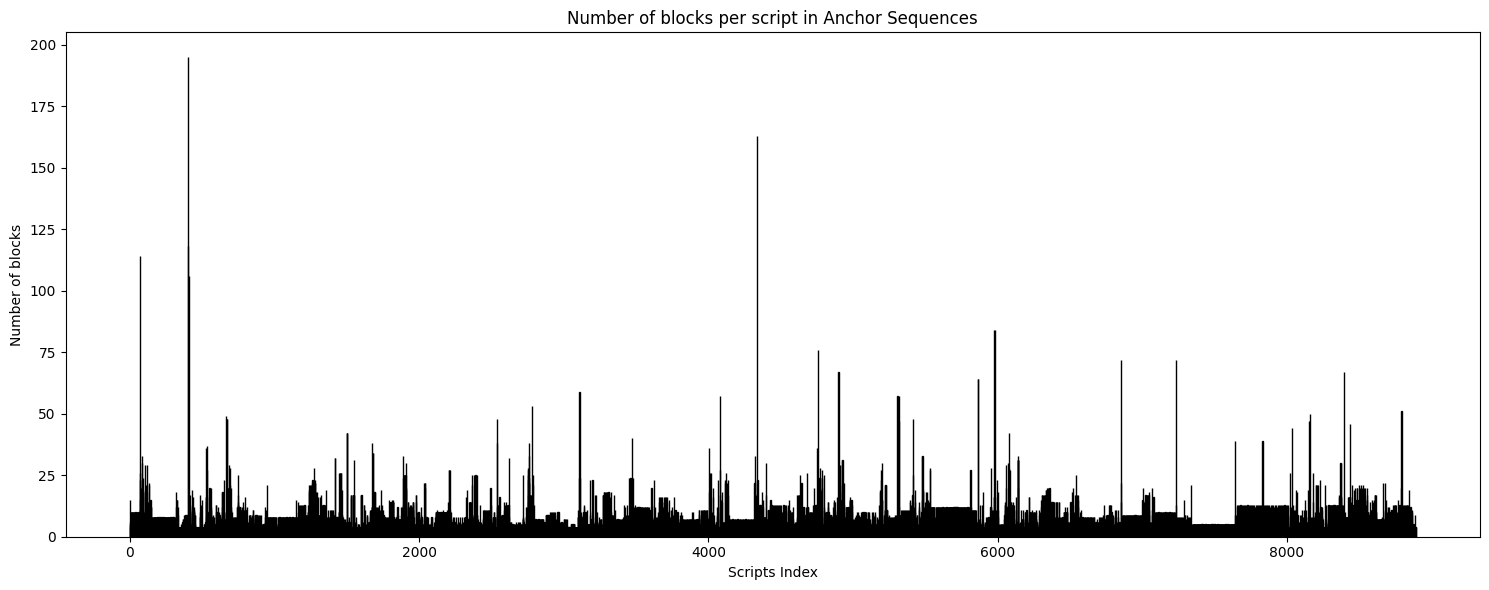

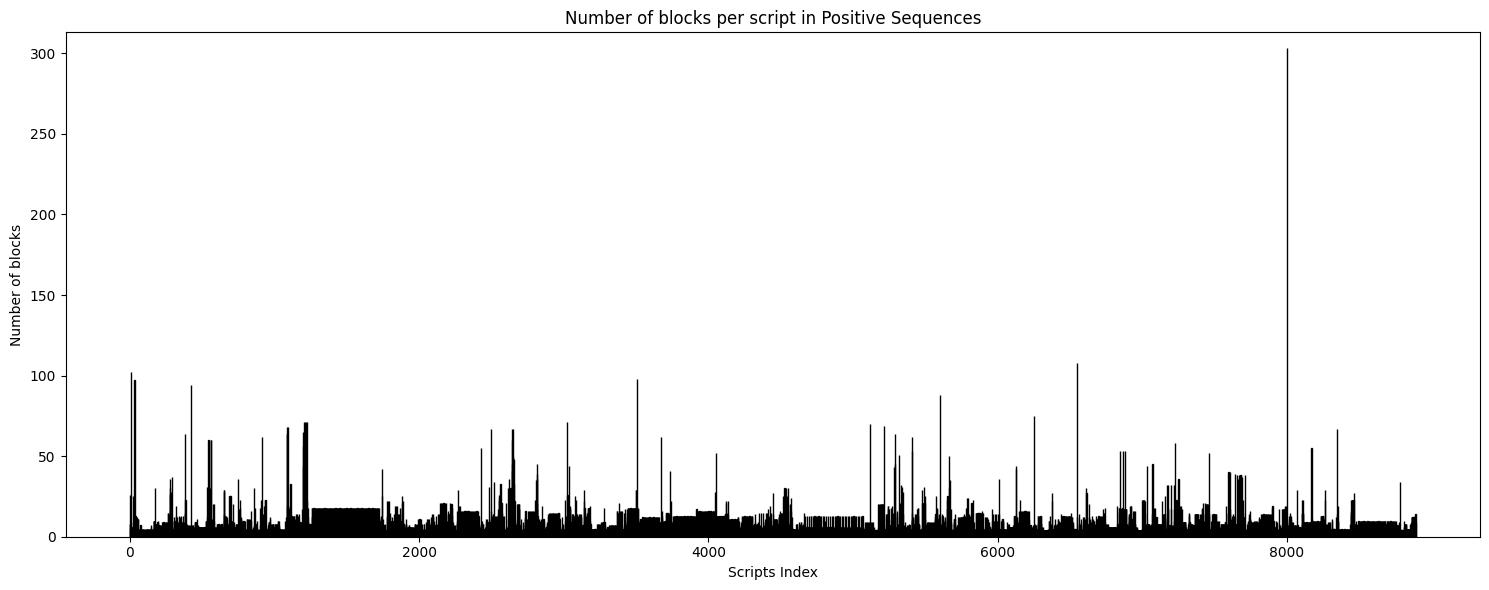

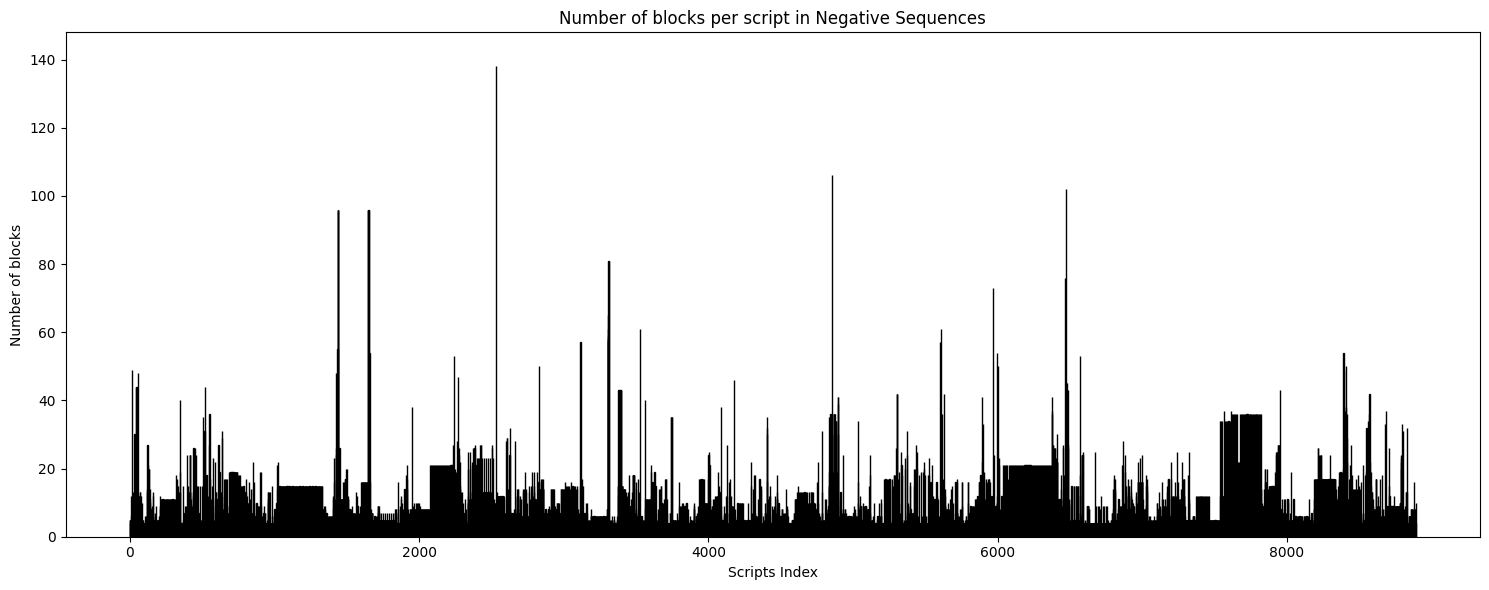

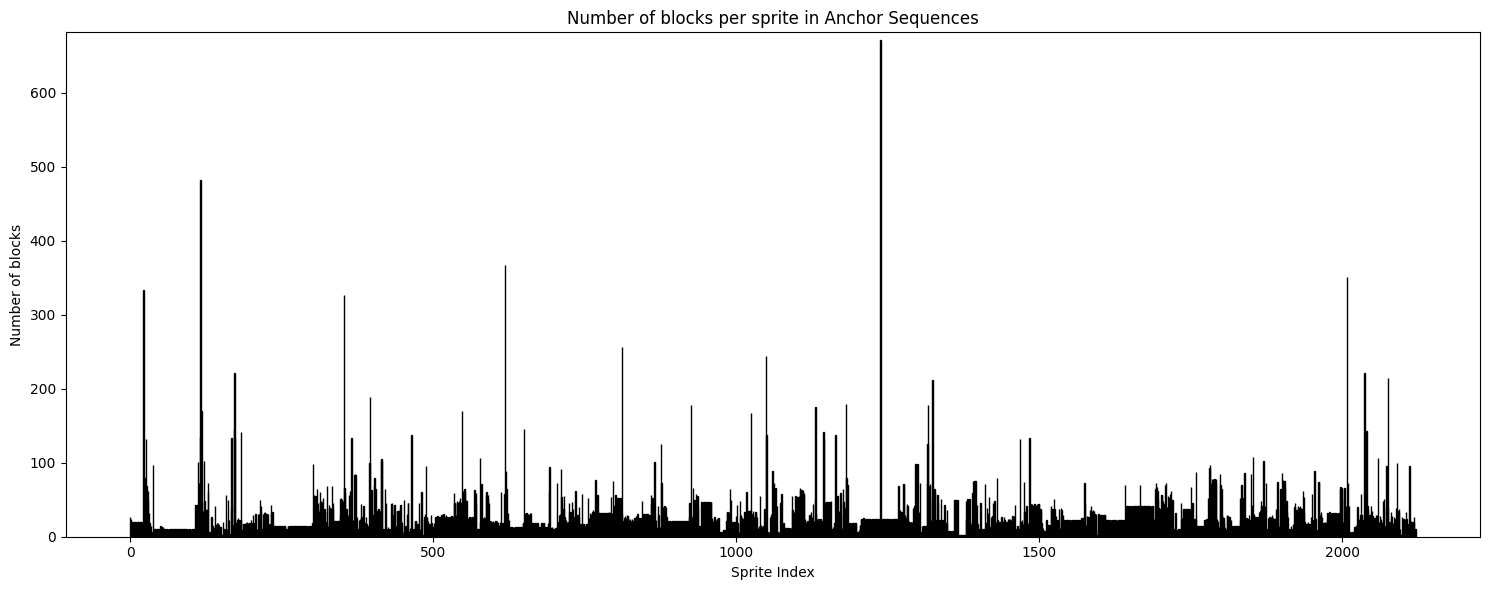

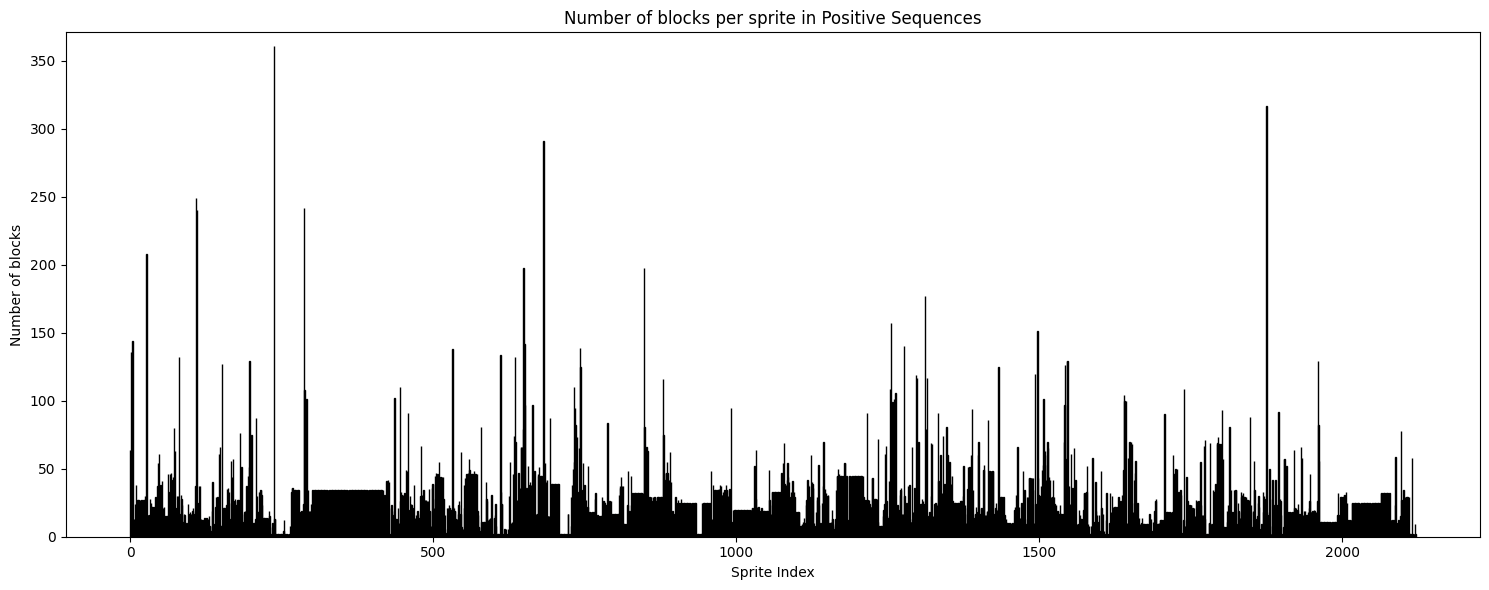

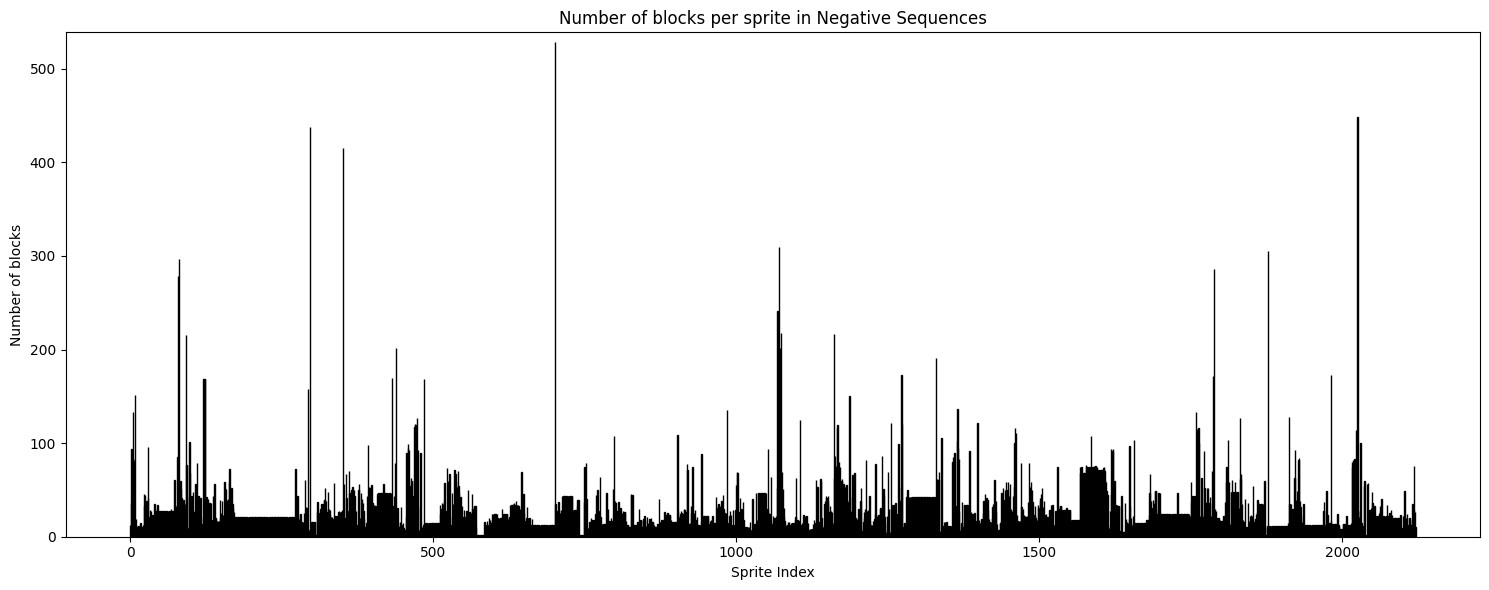

In [10]:

# Supongo que ya tienes scripts_train1, scripts_train2, scripts_train3 definidos
# Calcular la longitud de cada secuencia
def graph_num_seq_script(scripts, title, area):
    scripts_len = [len(script.split()) for script in scripts]
    
    # Configuración de las posiciones de las barras
    x = np.arange(len(scripts_len))  # Posición de las etiquetas en el eje X
    
    # Crear el gráfico de barras
    plt.figure(figsize=(15, 6))
    plt.bar(x, scripts_len, width=0.6, color='skyblue', edgecolor='black')
    
    # Ajustar los límites del eje Y
    plt.ylim(0, max(scripts_len) + 10)  # Agregar un margen de 10
    
    # Agregar etiquetas y título
    plt.xlabel(f'{area} Index')
    plt.ylabel('Number of blocks')
    plt.title(title)
    
    # Ajustar las etiquetas del eje X para mayor legibilidad
    #plt.xticks(x, [f'Script {i+1}' for i in x], rotation=45, ha='right')
    
    # Mostrar leyenda (opcional)
    # plt.legend(['Train 1'])
    
    # Mostrar gráfico
    plt.tight_layout()  # Ajusta el diseño para evitar recortes
    plt.show()

graph_num_seq_script(scripts_train1, 'Number of blocks per script in Anchor Sequences', 'Scripts')
graph_num_seq_script(scripts_train2, 'Number of blocks per script in Positive Sequences', 'Scripts')
graph_num_seq_script(scripts_train3, 'Number of blocks per script in Negative Sequences', 'Scripts')

graph_num_seq_script(scripts_train1_global, 'Number of blocks per sprite in Anchor Sequences', 'Sprite')
graph_num_seq_script(scripts_train2_global, 'Number of blocks per sprite in Positive Sequences', 'Sprite')
graph_num_seq_script(scripts_train3_global, 'Number of blocks per sprite in Negative Sequences', 'Sprite')

In [11]:
def build_vocab(scripts):
    blocks = [block for script in scripts for block in script.split() ]
    block_count = Counter(blocks)
    sorted_block_counts = sorted(block_count.items(), key=lambda x:x[1], reverse=True)
    block2idx = {
        '<pad>': 0,
        '<unk>': 1,
        '<SCRIPT_END>': 2,
        '<sos>': 3,
        '<eos>': 4
    }
    for idx, (block, _) in enumerate(sorted_block_counts, 3):
        block2idx[block] = idx
    idx2block = {idx: block for block, idx in block2idx.items()}
    return block2idx, idx2block

class TripletDataset(Dataset):
    def __init__(self, src_sentences, trg_sentences, neg_sentences, uni_block2idx, uni_idx2block):
        self.src_sentences = src_sentences  # Anchor (source)
        self.trg_sentences = trg_sentences  # Positive (target)
        self.neg_sentences = neg_sentences  # Negative
        self.src_block2idx = uni_block2idx
        self.trg_block2idx = uni_block2idx
        self.neg_block2idx = uni_block2idx
        self.src_idx2block = uni_idx2block
        self.trg_idx2block = uni_idx2block
        self.neg_idx2block = uni_idx2block
        
    def __len__(self):
        return len(self.trg_sentences)  # Usamos la longitud del conjunto positivo
    
    def __getitem__(self, idx):
        # Obtener las oraciones (anchor, positive, negative)
        src_sentence = self.src_sentences[idx]
        trg_sentence = self.trg_sentences[idx]
        neg_sentence = self.neg_sentences[idx]

        # Convertir cada oración en índices
        src_idxs = [self.src_block2idx.get(block, self.src_block2idx['<unk>']) for block in src_sentence.split()]
        trg_idxs = [self.trg_block2idx.get(block, self.trg_block2idx['<unk>']) for block in trg_sentence.split()]
        neg_idxs = [self.neg_block2idx.get(block, self.neg_block2idx['<unk>']) for block in neg_sentence.split()]

        # Retornar los tensores (anchor, positive, negative)
        return torch.tensor(src_idxs), torch.tensor(trg_idxs), torch.tensor(neg_idxs)

    def collate_fn_src(self):
        scripts = self.src_sentences
    
        src_sentence_list = []

        for script in scripts:
            script_list = script.split()
            fill_len = 128 - len(script_list)
            for i in range(fill_len):
                script_list.append('<pad>')
            src_sentence_list.append(" ".join(script_list))

        return src_sentence_list
        

In [12]:
scripts_universal = scripts_train1 + scripts_train2 + scripts_train3


# ------------- Universal scripts ----------------------------
uni_block2idx, uni_idx2block = build_vocab(scripts_universal)
uni_vocab_size = len(uni_block2idx)

# ------------- Local context --------------------------------
src_block2idx, src_idx2block = build_vocab(scripts_train1)
#src_vocab_size = len(src_block2idx)
src_vocab_size = uni_vocab_size
trg_block2idx, trg_idx2block = build_vocab(scripts_train2)
#trg_vocab_size = len(trg_block2idx)
trg_vocab_size = uni_vocab_size
neg_block2idx, neg_idx2block = build_vocab(scripts_train3)
#neg_vocab_size = len(neg_block2idx)
neg_vocab_size = uni_vocab_size
print(trg_vocab_size)
print(neg_vocab_size)
print(uni_block2idx)
# ------------ Global context -----------------------------
src_block2idx_global, src_idx2block_global = build_vocab(scripts_train1_global)
src_vocab_size_global = len(src_block2idx_global)
trg_block2idx_global, trg_idx2block_global = build_vocab(scripts_train2_global)
trg_vocab_size_global = len(trg_block2idx_global)
neg_block2idx_global, neg_idx2block_global = build_vocab(scripts_train3_global)
neg_vocab_size_global = len(neg_block2idx_global)

142
142
{'<pad>': 0, '<unk>': 1, '<SCRIPT_END>': 2, '<sos>': 3, '<eos>': 4, 'looks_hide': 5, 'event_whenflagclicked': 6, 'event_whenbackdropswitchesto': 7, 'control_if': 8, 'looks_show': 9, 'control_wait': 10, 'control_forever': 11, 'data_changevariableby': 12, 'motion_gotoxy': 13, 'sensing_touchingobject': 14, 'sensing_touchingobjectmenu': 15, 'event_whenbroadcastreceived': 16, 'operator_equals': 17, 'data_setvariableto': 18, 'looks_switchcostumeto': 19, 'looks_costume': 20, 'looks_backdrops': 21, 'looks_switchbackdropto': 22, 'looks_sayforsecs': 23, 'event_whenkeypressed': 24, 'event_broadcast': 25, 'motion_glidesecstoxy': 26, 'event_whenthisspriteclicked': 27, 'operator_random': 28, 'sound_sounds_menu': 29, 'sound_play': 30, 'sensing_keypressed': 31, 'sensing_keyoptions': 32, 'control_stop': 33, 'control_wait_until': 34, 'operator_and': 35, 'data_hidevariable': 36, 'operator_gt': 37, 'sensing_touchingcolor': 38, 'operator_lt': 39, 'motion_movesteps': 40, 'motion_changeyby': 41, 'con

## TRAIN FUNCTIONS

In [13]:
def collate_fn(batch):
    src_batch = zip(*batch)
    src_batch = [torch.tensor(seq) for seq in src_batch] 

    #print(trg_batch)
    # Hacemos el padding sin truncar primero
    #trg_batch = torch.nn.utils.rnn.pad_sequence(trg_batch, batch_first=True, padding_value=0)
    #src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=0)
    #neg_batch = torch.nn.utils.rnn.pad_sequence(neg_batch, batch_first=True, padding_value=0)
    
    # Ahora truncamos las secuencias después del padding a MAX_SEQ_LEN
    #trg_batch = trg_batch[:, :MAX_SEQ_LEN]
    #src_batch = src_batch[:, :MAX_SEQ_LEN]
    #neg_batch = neg_batch[:, :MAX_SEQ_LEN]

    src_batch = [torch.nn.functional.pad(seq[:MAX_SEQ_LEN], (0, MAX_SEQ_LEN - len(seq[:MAX_SEQ_LEN])), value=0) for seq in src_batch]

    src_batch = torch.stack(src_batch)
    
    return src_batch

def collate_fn_glob(batch):
    src_batch, pos_batch, neg_batch = zip(*batch)
    src_batch = [seq.clone().detach() for seq in src_batch]
    pos_batch = [seq.clone().detach() for seq in pos_batch]
    neg_batch = [seq.clone().detach() for seq in neg_batch]
    #print(trg_batch)
    # Hacemos el padding sin truncar primero
    #trg_batch = torch.nn.utils.rnn.pad_sequence(trg_batch, batch_first=True, padding_value=0)
    #src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=0)
    #neg_batch = torch.nn.utils.rnn.pad_sequence(neg_batch, batch_first=True, padding_value=0)
    
    # Ahora truncamos las secuencias después del padding a MAX_SEQ_LEN
    #trg_batch = trg_batch[:, :MAX_SEQ_LEN]
    #src_batch = src_batch[:, :MAX_SEQ_LEN]
    #neg_batch = neg_batch[:, :MAX_SEQ_LEN]

    src_batch = [torch.nn.functional.pad(seq[:MAX_SEQ_LEN], (0, MAX_SEQ_LEN - len(seq[:MAX_SEQ_LEN])), value=0) for seq in src_batch]
    pos_batch = [torch.nn.functional.pad(seq[:MAX_SEQ_LEN], (0, MAX_SEQ_LEN - len(seq[:MAX_SEQ_LEN])), value=0) for seq in pos_batch]
    neg_batch = [torch.nn.functional.pad(seq[:MAX_SEQ_LEN], (0, MAX_SEQ_LEN - len(seq[:MAX_SEQ_LEN])), value=0) for seq in neg_batch]

    src_batch = torch.stack(src_batch)    
    pos_batch = torch.stack(pos_batch)
    neg_batch = torch.stack(neg_batch)
    return src_batch, pos_batch, neg_batch

In [14]:
def train(model, dataloader, loss_function, optimiser, epochs):
    model.train()
    final_anchor_embeddings = []
    final_positive_embeddings = []
    final_negative_embeddings = []
    
    for epoch in range(epochs):
        total_loss = 0
        for i, (anchor_batch, positive_batch, negative_batch) in enumerate(dataloader):
            
            anchor_batch = anchor_batch.to(device)
            positive_batch = positive_batch.to(device)
            negative_batch = negative_batch.to(device)
            
            # Zero grads
            optimiser.zero_grad()

            # Forward para anchor, positive y negative
            anchor_embeddings = model(anchor_batch)
            positive_embeddings = model(positive_batch)
            negative_embeddings = model(negative_batch)
            
            # Almacenar los embeddings solo en el último epoch
            if epoch == epochs - 1:
                final_anchor_embeddings.append(anchor_embeddings.cpu().detach())
                final_positive_embeddings.append(positive_embeddings.cpu().detach())
                final_negative_embeddings.append(negative_embeddings.cpu().detach())


            

            # Calcular la pérdida de Triplet
            loss = loss_function(anchor_embeddings, positive_embeddings, negative_embeddings)

            # Backpropagation y actualización de parámetros
            loss.backward()
            optimiser.step()

            total_loss += loss.item()
            
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch: {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')
    
    # Concatenar los embeddings del último epoch
    final_anchor_embeddings = torch.cat(final_anchor_embeddings, dim=0)
    final_positive_embeddings = torch.cat(final_positive_embeddings, dim=0)
    final_negative_embeddings = torch.cat(final_negative_embeddings, dim=0)

    return final_anchor_embeddings, final_positive_embeddings, final_negative_embeddings


def evaluate(model, dataloader, reference_embeddings, loss_function=None):
    model = model.to(device)
    model.eval()  # Modo evaluación del modelo
    
    total_loss = 0

    with torch.no_grad():  # No calculamos gradientes en evaluación
        for i, project_batch in enumerate(dataloader):
            # Pasar el batch al dispositivo
            project_batch = project_batch.to(device)
            
            # Obtener embeddings del proyecto actual
            project_embeddings = model(project_batch)
            
    return project_embeddings

## **EVALUATION**

In [15]:

from collections import defaultdict



def calc_mean_embeddings(embeddings_2d, dataloader_local):
    token_embeddings = defaultdict(list)
    batches = []
    for src, _, _ in dataloader_local:
        batches.append(src)
    
    all_batches = torch.cat(batches, dim=0)
    all_batches = all_batches.view(all_batches.shape[0]*all_batches.shape[1])
    all_batches.shape
    
    for token_id, token_embedding in zip(all_batches, embeddings_2d):
        token_embeddings[token_id.item()].append(token_embedding)
    
    # Calcular la media de los embeddings para cada token
    mean_embeddings = {}
    for token_id, embeddings in token_embeddings.items():
        if embeddings:
            embeddings_array = np.stack([e.cpu().numpy() for e in embeddings])
            mean_embedding = np.mean(embeddings_array, axis=0)
            mean_embeddings[token_id] = mean_embedding
    
    # Mostrar resultados
    for token_id in list(mean_embeddings.keys())[:5]:  # Mostrar los primeros 5
        print(f"Token ID: {token_id}, Mean Embedding Shape: {mean_embeddings[token_id].shape}")
    return mean_embeddings

def graph_embeddings(mean_embeddings, title):
    tokens = list(mean_embeddings.keys())
    embeddings = np.array([mean_embeddings[token] for token in tokens])
    
    # Aplicar t-SNE para reducir a 2D
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Crear el gráfico
    plt.figure(figsize=(20, 16)) 
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
    
    # Etiquetar puntos
    for i, token in enumerate(tokens):
        plt.annotate(uni_idx2block[token], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)
    
    plt.title(f't-SNE Visualization of {title}')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()
    plt.savefig(f"{title}.png", dpi=300, bbox_inches='tight', transparent=True)


## LOCAL

In [16]:
model = torch.load('action_local_scratch_triplet.pth').to(device)
anchor_embeddings_local = model.get_embeddings()
print("Source embeddings:", anchor_embeddings_local.shape)

Source embeddings: torch.Size([8891, 128, 512])


In [79]:
train_src_embeddings_local_2d = anchor_embeddings_local.view(-1, 512)
dataset_local = TripletDataset(scripts_train1, scripts_train2, scripts_train3, uni_block2idx, uni_idx2block)
print("Embeddings total tokens:", train_src_embeddings_local_2d.shape)

Embeddings total tokens: torch.Size([1138048, 512])


In [80]:
BATCH_SIZE = 16
dataloader_local = DataLoader(dataset_local, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_glob)
tot_tk = 0
for src, trc, neg in dataloader_local:
    tot_tk +=src.shape[0]*src.shape[1]
"""
for script in src:
    print("NEW SCRIPT")
    for block in script:
        block = block.item()
        if block not in [0,1,2,3,4]:
            print(uni_idx2block.get(block, '<unk>'))
print(tot_tk)
"""

'\nfor script in src:\n    print("NEW SCRIPT")\n    for block in script:\n        block = block.item()\n        if block not in [0,1,2,3,4]:\n            print(uni_idx2block.get(block, \'<unk>\'))\nprint(tot_tk)\n'

torch.Size([1138048, 512])
Token ID: 3, Mean Embedding Shape: (512,)
Token ID: 6, Mean Embedding Shape: (512,)
Token ID: 4, Mean Embedding Shape: (512,)
Token ID: 0, Mean Embedding Shape: (512,)
Token ID: 27, Mean Embedding Shape: (512,)


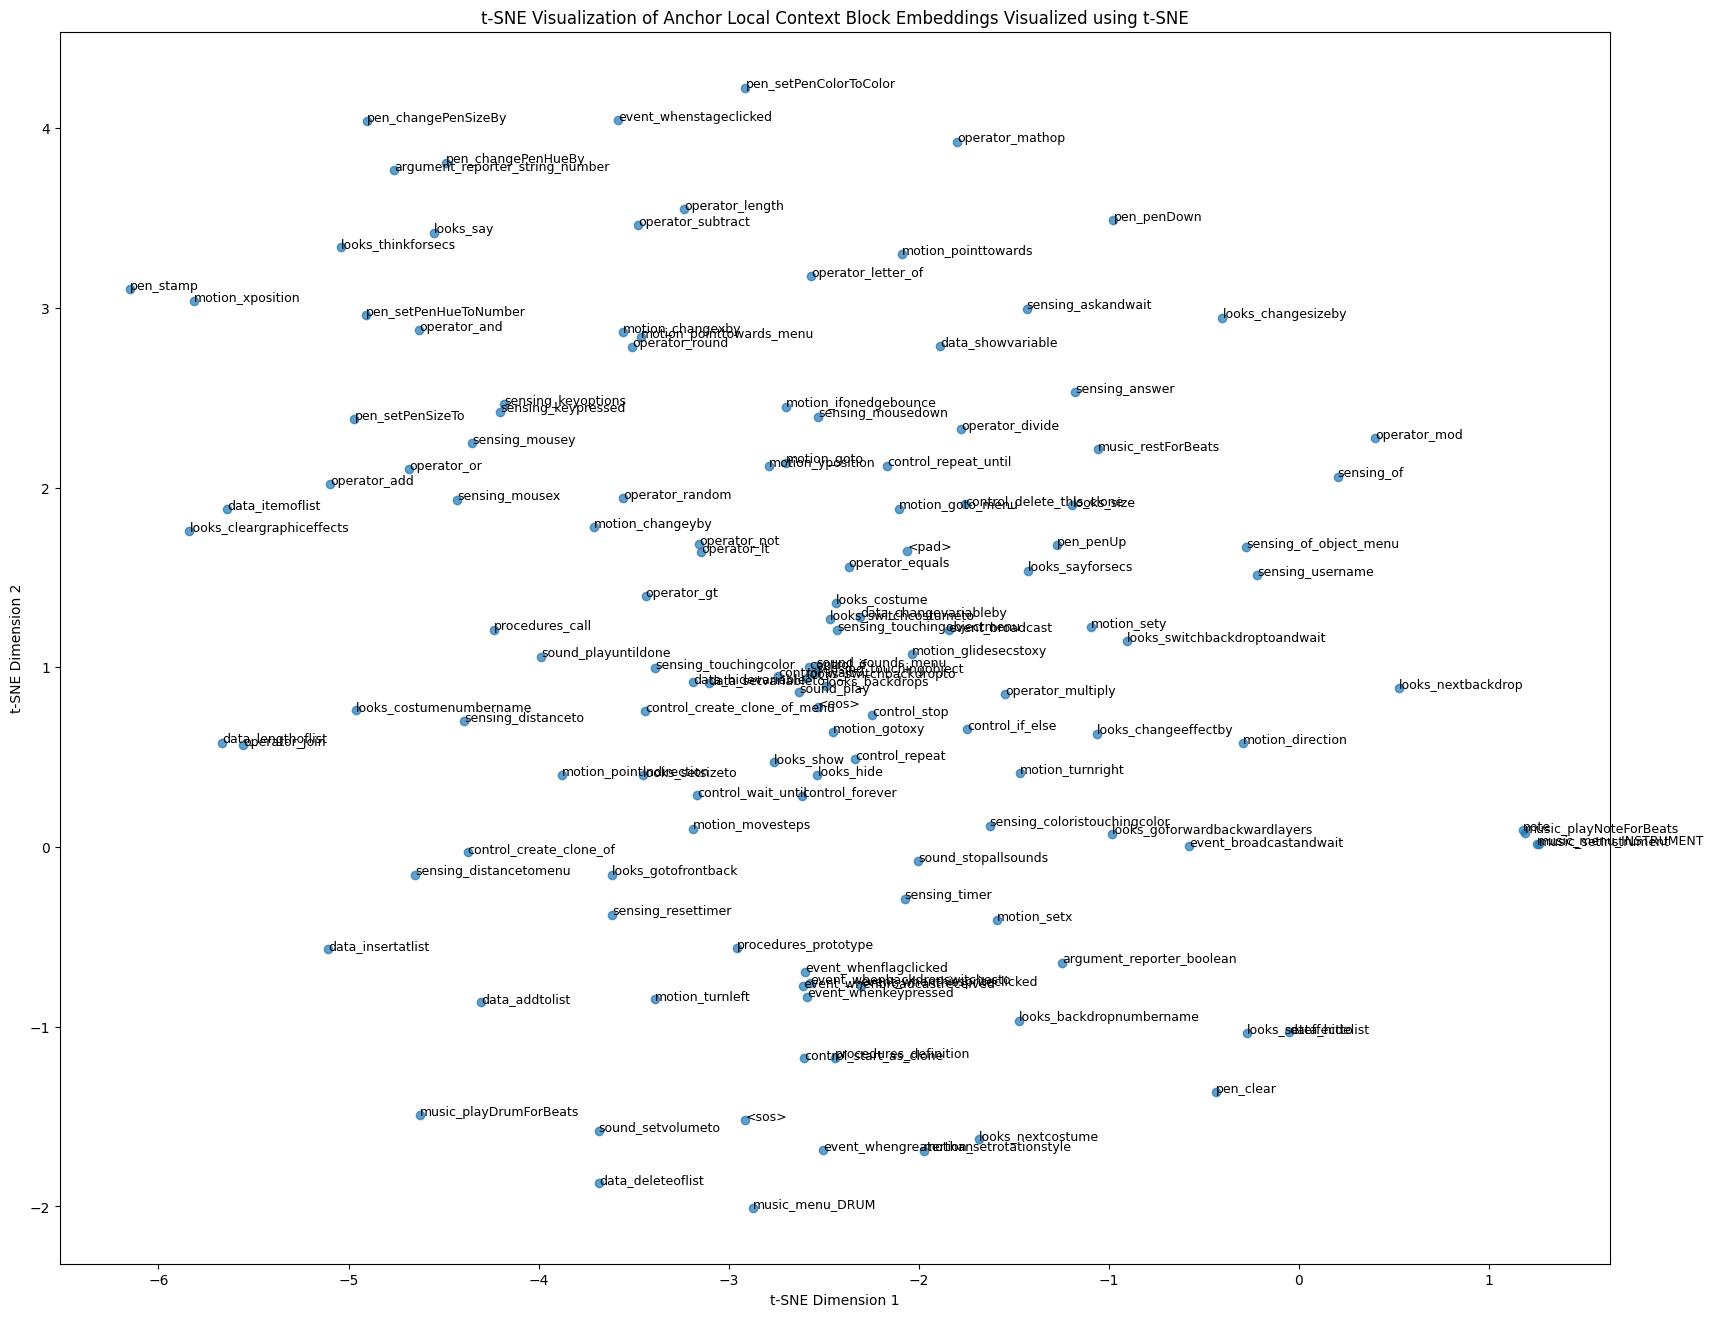

<Figure size 640x480 with 0 Axes>

In [81]:
local_elems = anchor_embeddings_local.shape[0] * anchor_embeddings_local.shape[1]
train_src_embeddings_local_2d = anchor_embeddings_local.view(local_elems, -1)
print(train_src_embeddings_local_2d.shape)

mean_embeddings_local = calc_mean_embeddings(train_src_embeddings_local_2d,dataloader_local)
# scripts_train1 it's my anchor in the training
graph_embeddings(mean_embeddings_local, "Anchor Local Context Block Embeddings Visualized using t-SNE")

## Global

In [82]:
modelglobal = torch.load('action_global_sprite_scratch_triplet.pth').to(device)
anchor_embeddings_global = modelglobal.get_embeddings()
print(anchor_embeddings_global[0])
print("Source embeddings:", anchor_embeddings_global.shape)

tensor([[ 0.0867,  1.1705, -1.1236,  ...,  1.8802,  0.2238, -0.2834],
        [ 0.3962,  1.8637, -1.1799,  ..., -0.3550, -0.9476,  0.4398],
        [ 0.5125,  0.2040,  0.8390,  ..., -0.1209, -1.1526,  0.2814],
        ...,
        [ 0.3572,  0.7347,  0.0077,  ...,  0.5195, -0.3087,  0.0568],
        [ 0.5333,  0.8886,  0.1159,  ...,  0.1682, -0.6429,  0.6903],
        [ 0.2507,  0.8122, -0.0556,  ...,  0.4547, -0.3534,  0.2294]])
Source embeddings: torch.Size([2122, 128, 512])


Token ID: 3, Mean Embedding Shape: (512,)
Token ID: 8, Mean Embedding Shape: (512,)
Token ID: 10, Mean Embedding Shape: (512,)
Token ID: 29, Mean Embedding Shape: (512,)
Token ID: 14, Mean Embedding Shape: (512,)


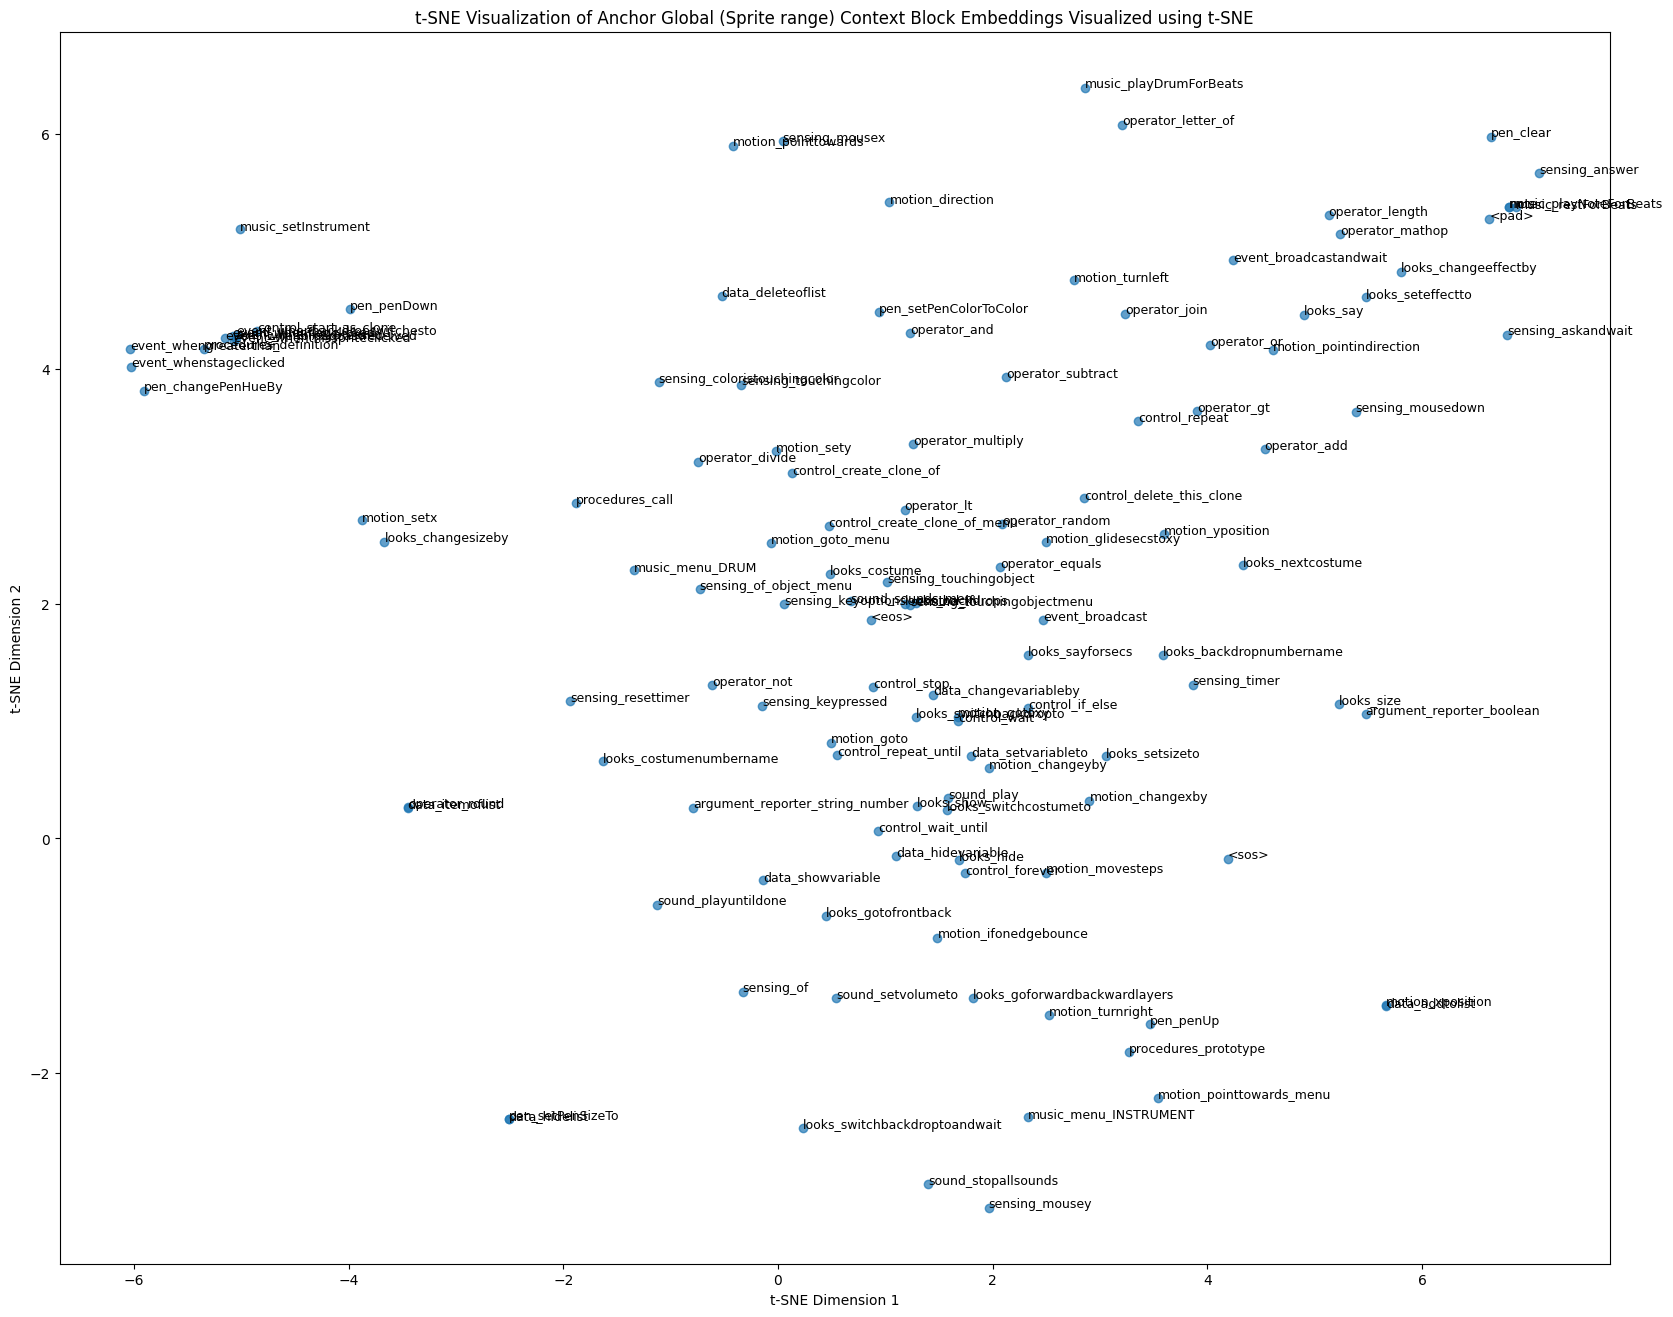

<Figure size 640x480 with 0 Axes>

In [83]:
dataset_global = TripletDataset(scripts_train1_global, scripts_train2_global, scripts_train3_global, uni_block2idx, uni_idx2block)
BATCH_SIZE = 16
dataloader_global = DataLoader(dataset_global, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_glob)
global_elems = anchor_embeddings_global.shape[0] * anchor_embeddings_global.shape[1]
train_src_embeddings_global_2d = anchor_embeddings_global.view(global_elems, -1)


mean_embeddings_global = calc_mean_embeddings(train_src_embeddings_global_2d,dataloader_local)
graph_embeddings(mean_embeddings_global, "Anchor Global (Sprite range) Context Block Embeddings Visualized using t-SNE")


# LOCAL & GLOBAL

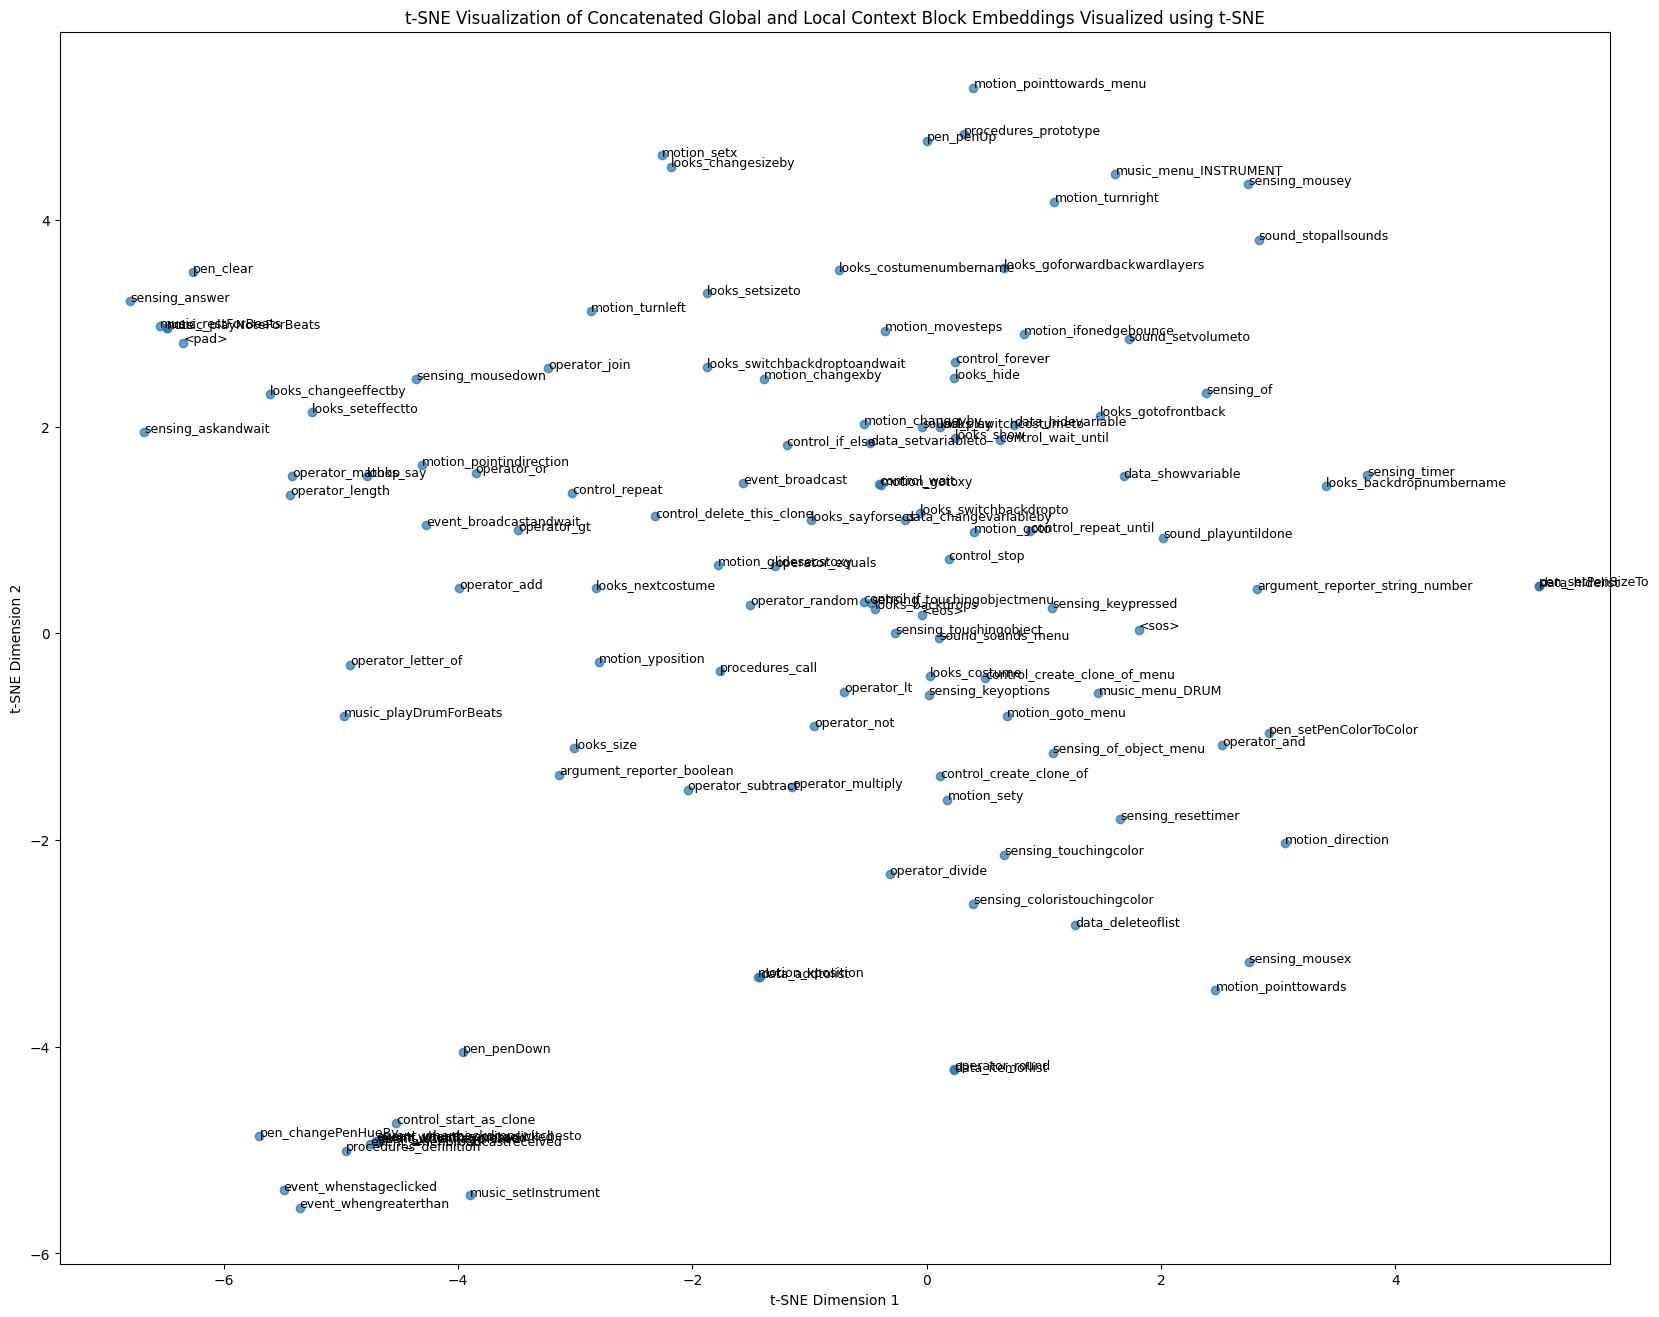

<Figure size 640x480 with 0 Axes>

In [84]:
concat_mean_embeddings_dict = {}  

for token_local, embedding_local in mean_embeddings_local.items():
    for token_global, embedding_global in mean_embeddings_global.items():
        if token_local == token_global:
            embedding_local = np.stack(embedding_local)
            embedding_global = np.stack(embedding_global)
            concat_mean_embeddings = np.mean([embedding_local, embedding_global], axis=0)
            concat_mean_embeddings_dict[token_local] = concat_mean_embeddings

graph_embeddings(concat_mean_embeddings_dict, "Concatenated Global and Local Context Block Embeddings Visualized using t-SNE")